# Description:

* Demultiplexing libraries from MiSeq run

## Setting variables (user input)

In [1]:
import os

seqdir = '/home/backup_files/raw_reads/fullcyc2.Barnett.2018/fullCyc2_lib4/run1'
workdir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib4'

# metadata file location(s)
metadata = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/FullCyc2_master_metadata.txt'

# Library
library = 'fullCyc2_lib4'

# Index and paired files
index_read1_file = 'index_read1.fq.gz'
index_read2_file = 'index_read2.fq.gz'
read12_screed = 'pear_merged-fullCyc2_lib4.assembled.fastq_screed'


## Init

In [2]:
import os
import json
import screed
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import screed
from glob import glob

In [3]:
%cd $workdir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib4


In [4]:
%load_ext rpy2.ipython
#%load_ext pushnote 

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


## Loading metadata tables

In [6]:
# loading metadata sheet
df_meta = pd.read_csv(os.path.join(seqdir, metadata), delimiter="\t")
df_meta.head(n=3)

,#Sample,primer_number,exp_type,extraction_plate_ID,library_ID,pool_plate_ID,pool_plate_well,soil_ID,substrate,day,...,water_holding_capacity__g.g,percent_N,percent_C,sand__perc,silt__perc,clay__perc,DNA_conc__ng_ul,notes,fwd_barcode,rev_barcode
0,EL.A.151026,129,bulk,14012016,Chantal_Pool9,NaN,NaN,EL.A.151026,NaN,NaN,...,0.778,0.20905,2.0399,40.0,26.7,33.3,19.965,NaN,CTACTATA,CGTACTCA
1,CC.M.151027.12C-Van.D02,129,Enrichment,Enr2_160509,fullCyc2_lib14,fullCyc2_lib14_pool_2,A5,CC.M.151027.12C-Van.D02,12C-Van,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,34.44,NaN,CTACTATA,CGTACTCA
2,MF.M.151026.12C-Ami.D02,129,Enrichment,Enr5_170113,fullCyc2_lib15,fullCyc2_lib15_pool_2,A5,MF.M.151026.12C-Ami.D02,12C-Ami,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,27.183,NaN,CTACTATA,CGTACTCA


In [7]:
# filter only metadata from this library
df_meta = pd.DataFrame(df_meta[df_meta.library_ID==library])
df_meta

,#Sample,primer_number,exp_type,extraction_plate_ID,library_ID,pool_plate_ID,pool_plate_well,soil_ID,substrate,day,...,water_holding_capacity__g.g,percent_N,percent_C,sand__perc,silt__perc,clay__perc,DNA_conc__ng_ul,notes,fwd_barcode,rev_barcode
6,MR.F.13C-Pal.D30.R2_Frac7,129,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,A5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.044,NaN,CTACTATA,CGTACTCA
19,MR.F.13C-Pal.D30.R2_Frac8,130,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,B5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.068,NaN,CGTTACTA,CGTACTCA
32,MR.F.13C-Pal.D30.R2_Frac9,131,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,C5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.027,NaN,AGAGTCAC,CGTACTCA
45,MR.F.13C-Pal.D30.R2_Frac10,132,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,D5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.054,NaN,TACGAGAC,CGTACTCA
58,MR.F.13C-Pal.D30.R2_Frac11,133,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,E5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.104,NaN,ACGTCTCG,CGTACTCA
71,MR.F.13C-Pal.D30.R2_Frac12,134,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,F5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.168,NaN,TCGACGAG,CGTACTCA
84,MR.F.13C-Pal.D30.R2_Frac13,135,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,G5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.607,NaN,GATCGTGT,CGTACTCA
98,MR.F.13C-Pal.D30.R2_Frac14,136,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,H5,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.848,NaN,GTCAGATA,CGTACTCA
112,MR.F.13C-Pal.D30.R2_Frac15,137,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,A6,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,CTACTATA,CTACGCAG
126,MR.F.13C-Pal.D30.R2_Frac16,138,SIP,NaN,fullCyc2_lib4,FullCyc2_lib4_Pool_2,B6,MR.F.13C-Pal.D30.R2,13C-Pal,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.154,NaN,CGTTACTA,CTACGCAG


# Uncompress index files and create screed db

In [8]:
def uncomp(fileName, directory):
    output = fileName.replace(".gz", "")
    fileName = os.path.join(directory, fileName)
    !cd $workdir; \
        pigz -k -d -p 10 -c -f $fileName > $output
    return os.path.splitext(output)[0]
    
index_read1_file = uncomp(index_read1_file, seqdir)
index_read2_file = uncomp(index_read2_file, seqdir)

In [9]:
os.chdir(workdir)
screed.read_fastq_sequences(index_read1_file+".fq")
screed.read_fastq_sequences(index_read2_file+".fq")

index_read1_screed = index_read1_file + '.fq_screed'
index_read2_screed = index_read2_file + '.fq_screed'

# Demultiplex

In [10]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)    

In [11]:
# loading/editing metadata

df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]


## format of barcode=>sample dict: [revBarcode=read1 + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [15]:
# resulting dict of sample => barcode_FR 
n_print = 176

[(list(map_d.keys())[i], map_d[list(map_d.keys())[i]]) for i in range(n_print)]

[('tgagtacgctactata', 'MR.F.13C-Pal.D30.R2_Frac7'),
 ('tgagtacgcgttacta', 'MR.F.13C-Pal.D30.R2_Frac8'),
 ('tgagtacgagagtcac', 'MR.F.13C-Pal.D30.R2_Frac9'),
 ('tgagtacgtacgagac', 'MR.F.13C-Pal.D30.R2_Frac10'),
 ('tgagtacgacgtctcg', 'MR.F.13C-Pal.D30.R2_Frac11'),
 ('tgagtacgtcgacgag', 'MR.F.13C-Pal.D30.R2_Frac12'),
 ('tgagtacggatcgtgt', 'MR.F.13C-Pal.D30.R2_Frac13'),
 ('tgagtacggtcagata', 'MR.F.13C-Pal.D30.R2_Frac14'),
 ('ctgcgtagctactata', 'MR.F.13C-Pal.D30.R2_Frac15'),
 ('ctgcgtagcgttacta', 'MR.F.13C-Pal.D30.R2_Frac16'),
 ('ctgcgtagagagtcac', 'MR.F.13C-Pal.D30.R2_Frac17'),
 ('ctgcgtagtacgagac', 'MR.F.13C-Pal.D30.R2_Frac18'),
 ('ctgcgtagacgtctcg', 'MR.F.13C-Pal.D30.R2_Frac19'),
 ('ctgcgtagtcgacgag', 'MR.F.13C-Pal.D30.R2_Frac20'),
 ('ctgcgtaggatcgtgt', 'MR.F.13C-Pal.D30.R2_Frac21'),
 ('ctgcgtaggtcagata', 'MR.F.13C-Pal.D30.R2_Frac22'),
 ('tagtctccctactata', 'MR.F.13C-Pal.D30.R2_Frac23'),
 ('tagtctcccgttacta', 'MR.F.13C-Pal.D30.R2_Frac24'),
 ('tagtctccagagtcac', 'MR.F.13C-Pal.D30.R2_Frac25

In [16]:
# loading screed databases 
ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed)

In [17]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workdir, os.path.split(outFile)[1])
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["quality"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print ("Unable to assign %s reads to samples"%unassigned)

Unable to assign 3017063 reads to samples


In [18]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print('Number of sequences: {}'.format(n_lines/4))

Number of sequences: 5249241.0


# Stats on sequences

## Number of sequences per sample

In [19]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [20]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(seq_cnt, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.M.13C-Xyl.D6.R1_Frac19,30020
1,MR.A.13C-Ami.D3.R1_Frac6,79180
2,MR.F.13C-Xyl.D14.R3_Frac7,41446
3,MR.F.13C-Cel.D14.R2_Frac28,37590
4,MR.M.13C-Xyl.D6.R1_Frac13,41520
5,MR.A.13C-Ami.D3.R1_Frac24,45195
6,MR.A.13C-Ami.D3.R1_Frac9,51037
7,MR.M.13C-Xyl.D6.R1_Frac9,47911
8,MR.F.12C-Con.D14.R1_Frac27,65226
9,MR.M.13C-Xyl.D6.R1_Frac16,55540


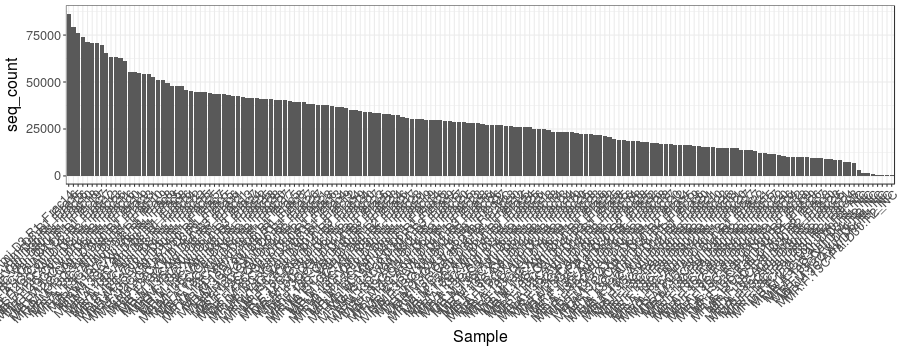

In [21]:
%%R -i df_seq_cnt -w 900 -h 350

df_seq_cnt$Sample = reorder(df_seq_cnt$Sample, desc(df_seq_cnt$seq_count))

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [22]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                        Sample seq_count
32      MR.A.13C-Ami.D14.R1_NC       556
39  MR.A.13C-Ami.D14.R1_Frac18      9956
40   MR.F.13C-Pal.D30.R2_Frac7      9313
45  MR.F.13C-Pal.D30.R2_Frac25      8573
49  MR.A.13C-Ami.D14.R1_Frac23      8696
51  MR.F.13C-Pal.D30.R2_Frac24      7302
61  MR.F.13C-Pal.D30.R2_Frac23      6759
73  MR.F.13C-Pal.D30.R2_Frac11      7326
106 MR.A.13C-Ami.D14.R1_Frac26      9315
117 MR.A.13C-Ami.D14.R1_Frac10      9093
134      MR.A.13C-Ami.D3.R1_NC      1591
156     MR.F.13C-Cel.D14.R2_NC      1147
158  MR.F.13C-Pal.D30.R2_Frac8      9259
164  MR.F.13C-Pal.D30.R2_Frac9      9896
167     MR.F.12C-Con.D14.R1_NC      3273
168      MR.M.13C-Xyl.D6.R1_NC       699
169 MR.F.13C-Pal.D30.R2_Frac19      9664
171     MR.M.13C-Van.D30.R1_NC      1749
174     MR.F.13C-Pal.D30.R2_NC       262
175     MR.F.13C-Xyl.D14.R3_NC       721


### Are the number of samples returned the same as expected?

In [23]:
print ("You got " + str(len(df_seq_cnt)) + " samples")
print ("You should have " + str(len(df_meta)) + " samples")


You got 176 samples
You should have 176 samples
